In [2]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.compat.v1.Session(config=config))

2023-06-06 00:27:12.666218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 00:27:19.172807: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/cv2/../../lib64::/usr/local/cuda-11.6/lib64:/usr/local/cuda-11.6/lib64
2023-06-06 00:27:19.173375: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

In [3]:
label_path = './input/labels.csv'
image_path = './input/head_ct/head_ct'

label_df = pd.read_csv(label_path)
image_files = sorted(glob.glob(image_path + '/*.png'))
labels = np.array(label_df[' hemorrhage'].tolist())

random_state = 42

In [4]:
# load images
images = np.array([cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in image_files])
images.shape, images[0].shape

/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


((200,), (957, 821))

In [5]:
# stat image width and height
images_df = pd.DataFrame(images, columns=['image'])
images_df['width'] = images_df['image'].apply(lambda x: x.shape[0])
images_df['height'] = images_df['image'].apply(lambda x: x.shape[1])
images_df['label'] = labels
images_df['label'] = images_df['label'].apply(lambda x: 'Not Hemorrhage' if x == 1 else 'Hemorrhage')

<AxesSubplot:xlabel='label', ylabel='count'>

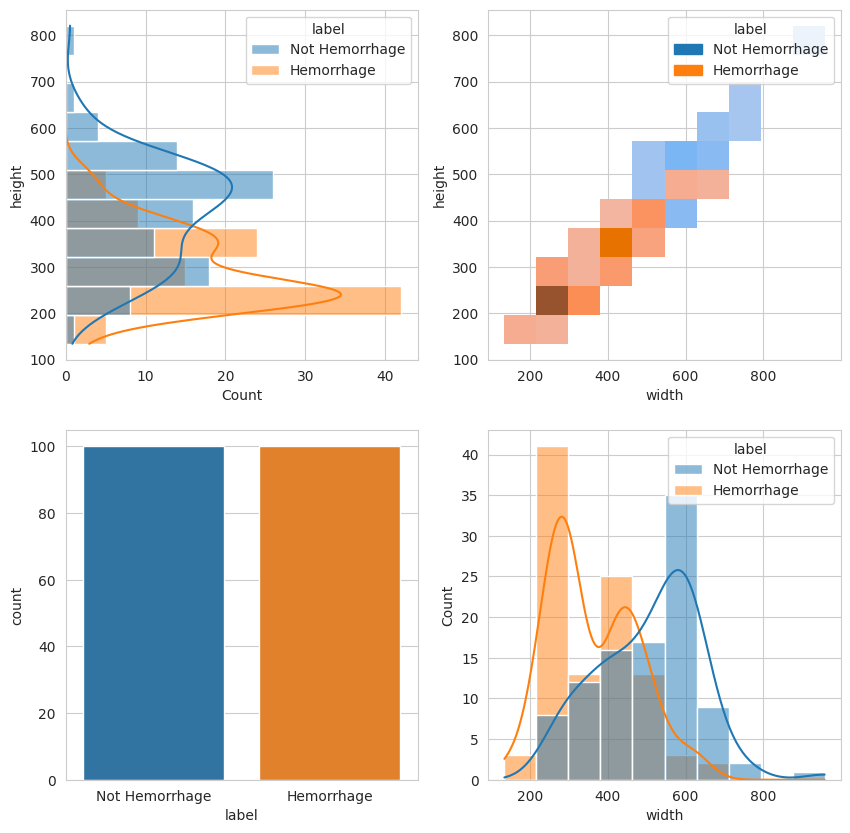

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(x='width', data=images_df, ax=ax[1][1], hue='label', kde=True)
sns.histplot(y='height', data=images_df, ax=ax[0][0], hue='label', kde=True)
sns.histplot(x='width', y='height', data=images_df, ax=ax[0][1], hue='label')
sns.countplot(x='label', data=images_df, ax=ax[1][0])

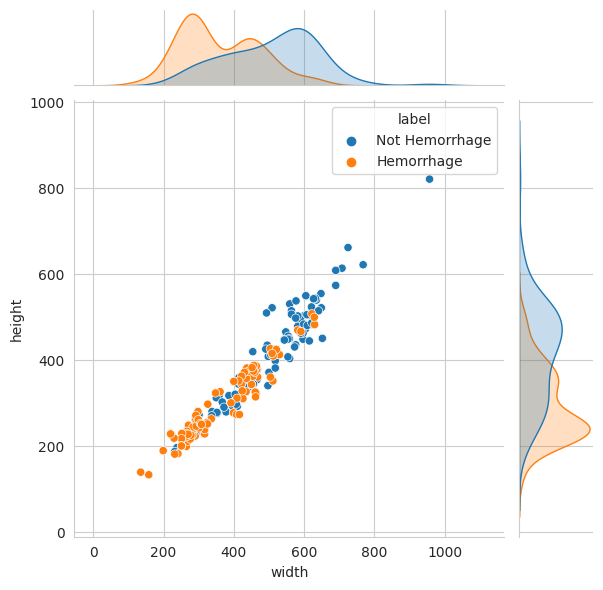

In [7]:
sns.jointplot(x='width', y='height', data=images_df, hue='label')

In [8]:
from PIL import Image, ImageEnhance

def feature_engineering(img, size=(252, 252)):
    img = Image.fromarray(img)  # openCV to PIL

    img = ImageEnhance.Contrast(img)  # 1 contrast enhancement
    contrast = 2
    img = img.enhance(contrast)
    img = np.asarray(img)  # PIL to openCV
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # 2 gray scale
    thresh = (img.max() - img.min()) // 1.6  # binarize threshold
    _, img = cv2.threshold(img, thresh, 1, cv2.THRESH_BINARY)  # 3 binarize
    img = cv2.medianBlur(img, 7)  # 4 median blur
    img = cv2.erode(img, np.ones((3, 3), np.uint8), iterations=2)  # 5 erode
    img = cv2.resize(img, size)  # 6 resize

    return img

In [9]:
featured = np.array([feature_engineering(image,(252,252)) for image in images])
featured_flatten = np.array([image.flatten() for image in featured])

In [10]:
#autoencoder

import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

In [11]:
def autoencoder_model(input_shape):
    input_img = keras.Input(shape=input_shape)

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    encoder = keras.Model(input_img, encoded)
    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.summary()
    return encoder, autoencoder

In [12]:
encoder, autoencoder = autoencoder_model((252, 252, 1))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 252, 252, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 252, 252, 16)      160       
                                                                 


2023-06-06 00:27:36.597516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 00:27:36.597824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 00:27:36.598051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 00:27:36.598543: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 00:27:36.598786: I tensorflow/compiler/xla/stream_executo

 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 8)         584       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 max_pooli

In [13]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 252, 252, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 252, 252, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 8)         584 

In [14]:
featured_ae = np.reshape(featured, (featured.shape[0], 252, 252, 1))
X_train, X_test, y_train, y_test = train_test_split(featured_ae, labels, test_size=0.2, shuffle=True, random_state=random_state, stratify=labels)

In [15]:
# autoencoder.fit(X_train, X_train,
#                 epochs=5000,
#                 batch_size=256,
#                 shuffle=True,
#                 validation_data=(X_test, X_test),
#                 verbose=1,
#                 callbacks=[keras.callbacks.ModelCheckpoint('./models/autoencoder.h5', monitor='val_loss', save_best_only=True, verbose=1)])

2023-06-06 00:27:42.485891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500


2/2 [==============================] - 8s 33ms/step


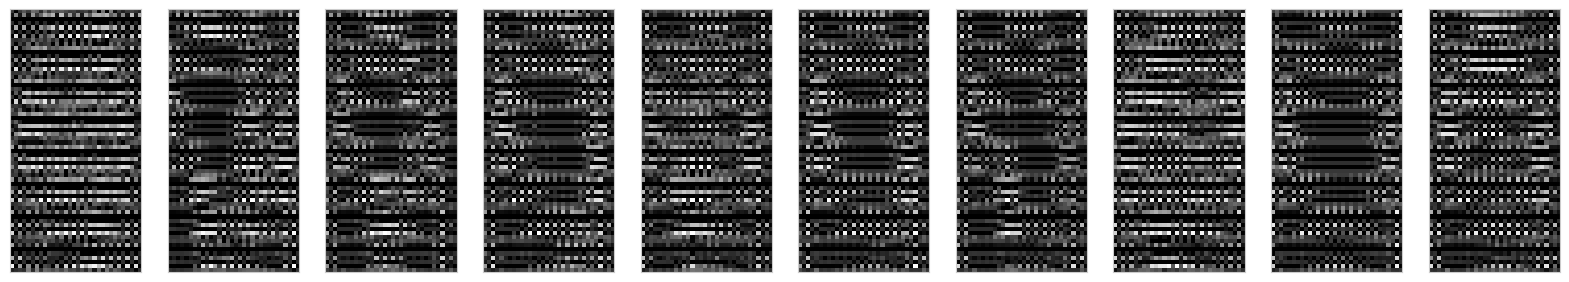

In [16]:
# encoder visualization
autoencoder = keras.models.load_model('./models/autoencoder.h5')
encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('max_pooling2d_3').output)
encoded_imgs = encoder.predict(X_test)

x = 16
n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((2048//64,64)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

2/2 [==============================] - 0s 30ms/step


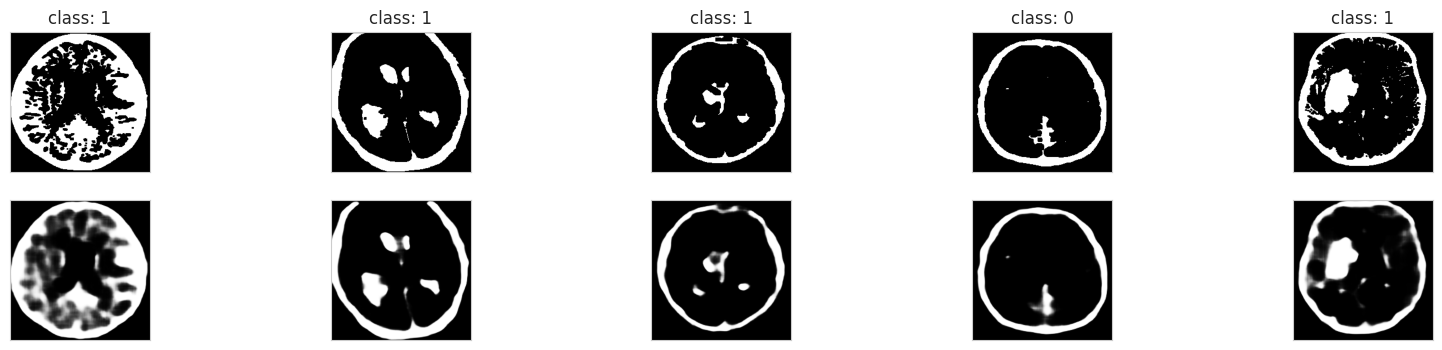

In [17]:
# autoencoder visualization
decoded_imgs = autoencoder.predict(X_test)

n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(252, 252))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('class: {}'.format(y_test[i]))

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(252, 252))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
# feature extraction
encoded = encoder.predict(featured_ae)
encoded = encoded.astype('float32') * 255.
encoded = encoded.astype(np.uint8)
encoded = np.array([image.reshape(64,2048//64) for image in encoded])

7/7 [==============================] - 0s 1ms/step


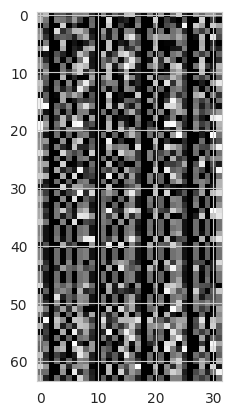

In [19]:
plt.imshow(encoded[0])

In [20]:
# heatmap
heatmap = encoded.astype(np.uint8)
heatmap = np.array([cv2.resize(image, (2048//64, 64)) for image in heatmap])
heatmap = 255 - heatmap
heatmap = np.array([cv2.applyColorMap(image, cv2.COLORMAP_JET) for image in heatmap])

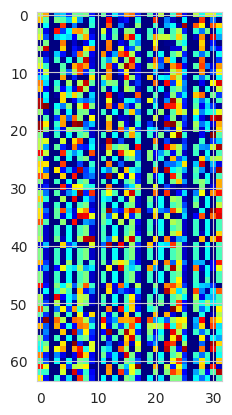

In [21]:
plt.imshow(heatmap[0])

In [22]:
# original image
original = np.array([cv2.resize(image, (252, 252)) for image in images])

In [23]:
# muplitple

In [24]:
from torchvision import transforms, datasets, utils

In [25]:
T = transforms.Compose([transforms.RandomResizedCrop((252, 252),
                                                     scale=(0.6, 1),
                                                     ratio=(0.5, 2)),
                        transforms.RandomRotation(30),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip()])

In [26]:
def Transform(image):
    image = Image.fromarray(image)
    image = T(image)
    image = np.array(image)
    return image

In [27]:
def multiple(X,y, n):
    X_new = []
    y_new = []
    for i in range(X.shape[0]):
        for j in range(n):
            X_new.append(Transform(X[i]))
            y_new.append(y[i])
    return np.array(X_new), np.array(y_new)

In [28]:
# multiple images
original10x, labels10x = multiple(original, labels, 10)

featured10x = np.array([feature_engineering(image,(252,252)) for image in original10x])

featured10x_ae = np.reshape(featured10x, (featured10x.shape[0], 252, 252, 1))
encoded10x = encoder.predict(featured10x_ae)
encoded10x = encoded10x.astype('float32') * 255.
encoded10x = encoded10x.astype(np.uint8)
encoded10x = np.array([image.reshape(64,2048//64) for image in encoded10x])

heatmap10x = encoded10x.astype(np.uint8)
heatmap10x = np.array([cv2.resize(image, (2048//64, 64)) for image in heatmap10x])
heatmap10x = 255 - heatmap10x
heatmap10x = np.array([cv2.applyColorMap(image, cv2.COLORMAP_JET) for image in heatmap10x])

63/63 [==============================] - 2s 2ms/step


In [29]:
original.shape,featured.shape,encoded.shape,heatmap.shape

((200, 252, 252), (200, 252, 252), (200, 64, 32), (200, 64, 32, 3))

In [29]:
original10x.shape,featured10x.shape,encoded10x.shape,heatmap10x.shape

((2000, 252, 252), (2000, 252, 252), (2000, 64, 32), (2000, 64, 32, 3))

In [32]:
# SVM

In [33]:
def metrics(model,X_test,y_test):
    acc = model.score(X_test, y_test) * 100
    print(acc)
    svm_y_pred = model.predict_proba(X_test)[:, 1]
    svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_pred)
    svm_auc = auc(svm_fpr, svm_tpr)
    plt.figure()
    plt.plot(svm_fpr, svm_tpr, color='green', lw=2, label='SVM ROC curve (AUC = %0.2f)' % svm_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()  # 混淆矩阵
    svm_pred = model.predict(X_test)
    cfm = confusion_matrix(y_test, svm_pred)
    print("SVM Confusion Matrix: \n", cfm)
    sensitivity = cfm[0, 0] / (cfm[0, 0] + cfm[0, 1])
    print("Sensitivity : ", sensitivity)
    specificity = cfm[1, 1] / (cfm[1, 0] + cfm[1, 1])
    print("Specificity : ", specificity)
    precision = cfm[0, 0] / (cfm[0, 0] + cfm[1, 0])
    print("Precision : ", precision)
    F1score = 2*cfm[0, 0] / (2*cfm[0, 0] + cfm[0, 1] + cfm[1, 0])
    print("F1score : ", F1score)
    acc = (cfm[0, 0] + cfm[1, 1]) / (cfm[0, 0] + cfm[0, 1] + cfm[1, 0] + cfm[1, 1])
    print("Accuracy : ", acc)

In [34]:
def SVMCls(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=random_state, stratify=y)
    clf = SVC(kernel='rbf', probability=True)
    print("Fitting SVM Classifier...")
    clf.fit(X_train, y_train)
    print("SVM Classifier Fitted...")
    metrics(clf,X_test,y_test)

Fitting SVM Classifier...
SVM Classifier Fitted...
76.66666666666667


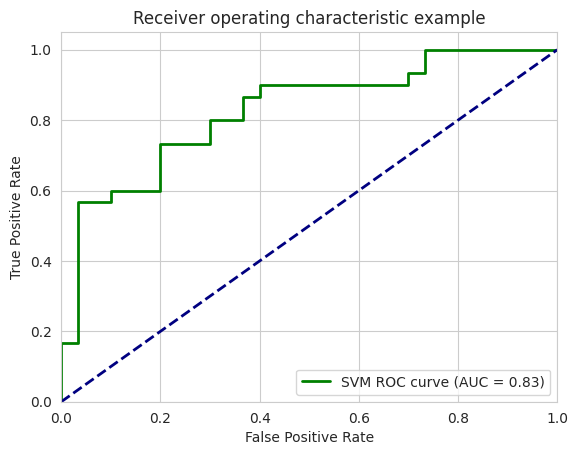

SVM Confusion Matrix: 
 [[24  6]
 [ 8 22]]
Sensitivity :  0.8
Specificity :  0.7333333333333333
Precision :  0.75
F1score :  0.7741935483870968
Accuracy :  0.7666666666666667


In [33]:
# Original
original_flatten = np.array([image.flatten() for image in original])
SVMCls(original_flatten,labels)

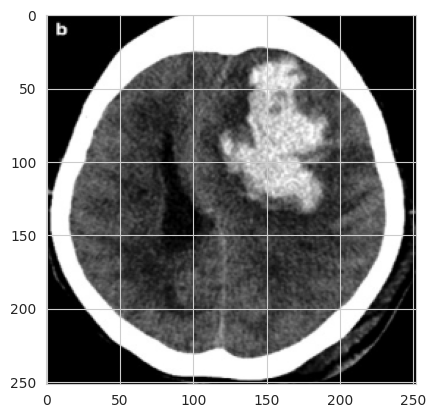

In [34]:
plt.imshow(original[0])

Fitting SVM Classifier...
SVM Classifier Fitted...
80.0


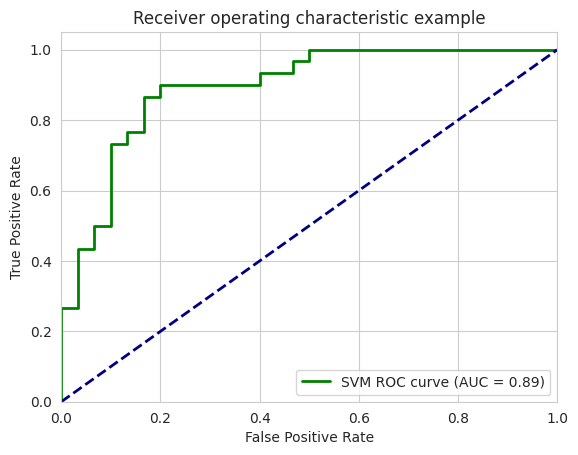

SVM Confusion Matrix: 
 [[25  5]
 [ 7 23]]
Sensitivity :  0.8333333333333334
Specificity :  0.7666666666666667
Precision :  0.78125
F1score :  0.8064516129032258
Accuracy :  0.8


In [35]:
# Encoded
encoded_flatten = np.array([image.flatten() for image in encoded])
SVMCls(encoded_flatten,labels)

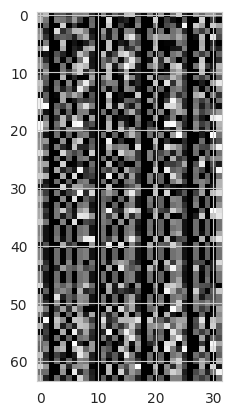

In [36]:
plt.imshow(encoded[0])

Fitting SVM Classifier...
SVM Classifier Fitted...
81.66666666666667


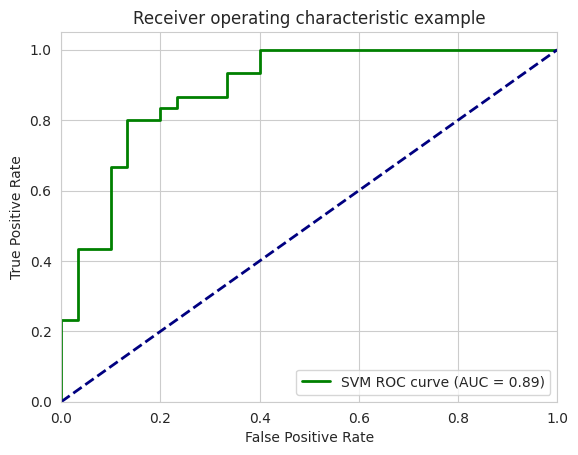

SVM Confusion Matrix: 
 [[24  6]
 [ 5 25]]
Sensitivity :  0.8
Specificity :  0.8333333333333334
Precision :  0.8275862068965517
F1score :  0.8135593220338984
Accuracy :  0.8166666666666667


In [37]:
# Heatmap
heatmap_flatten = np.array([image.flatten() for image in heatmap])
SVMCls(heatmap_flatten,labels)

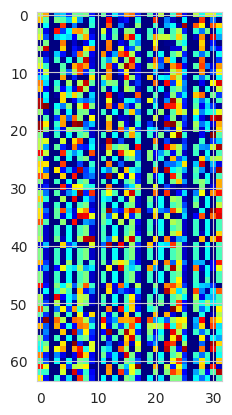

In [38]:
plt.imshow(heatmap[0])

Fitting SVM Classifier...
SVM Classifier Fitted...
78.33333333333333


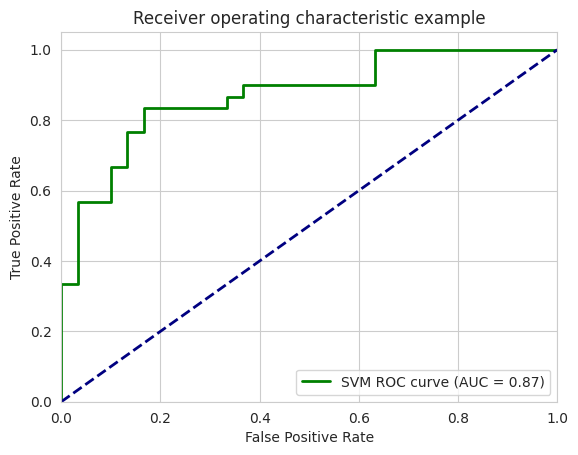

SVM Confusion Matrix: 
 [[27  3]
 [10 20]]
Sensitivity :  0.9
Specificity :  0.6666666666666666
Precision :  0.7297297297297297
F1score :  0.8059701492537313
Accuracy :  0.7833333333333333


In [39]:
# feature
featured_flatten = np.array([image.flatten() for image in featured])
SVMCls(featured_flatten,labels)

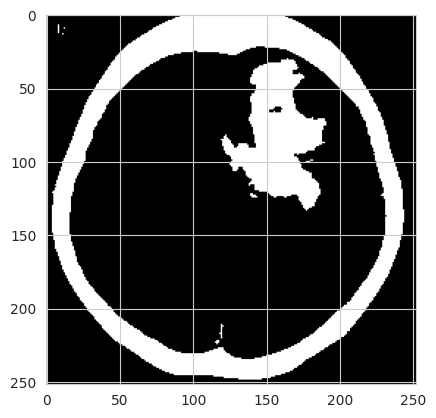

In [40]:
plt.imshow(featured[0])

Fitting SVM Classifier...
SVM Classifier Fitted...
80.0


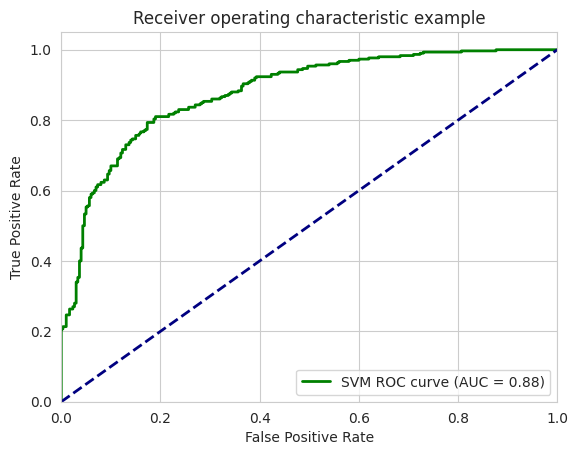

SVM Confusion Matrix: 
 [[253  47]
 [ 73 227]]
Sensitivity :  0.8433333333333334
Specificity :  0.7566666666666667
Precision :  0.7760736196319018
F1score :  0.8083067092651757
Accuracy :  0.8


In [41]:
# Original 10x
original10x_flatten = np.array([image.flatten() for image in original10x])
SVMCls(original10x_flatten,labels10x)

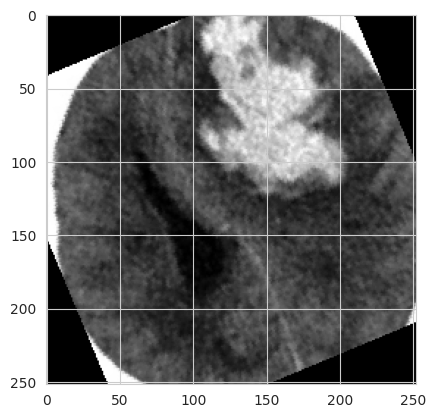

In [42]:
plt.imshow(original10x[0])

Fitting SVM Classifier...
SVM Classifier Fitted...
83.33333333333334


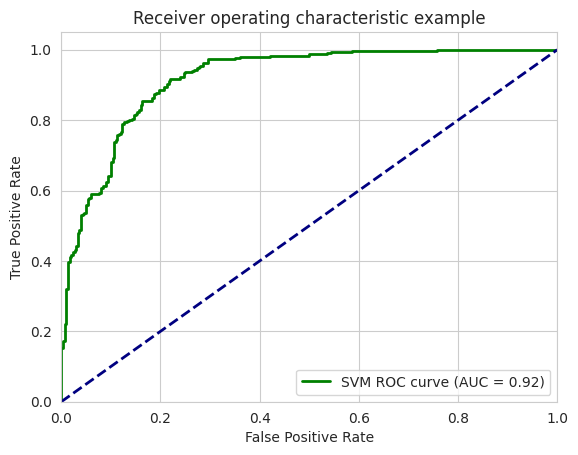

SVM Confusion Matrix: 
 [[253  47]
 [ 53 247]]
Sensitivity :  0.8433333333333334
Specificity :  0.8233333333333334
Precision :  0.826797385620915
F1score :  0.834983498349835
Accuracy :  0.8333333333333334


In [43]:
# Encoded 10x
encoded10x_flatten = np.array([image.flatten() for image in encoded10x])
SVMCls(encoded10x_flatten,labels10x)

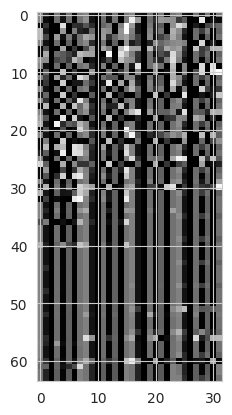

In [76]:
plt.imshow(encoded10x[0])

Fitting SVM Classifier...
SVM Classifier Fitted...
83.16666666666667


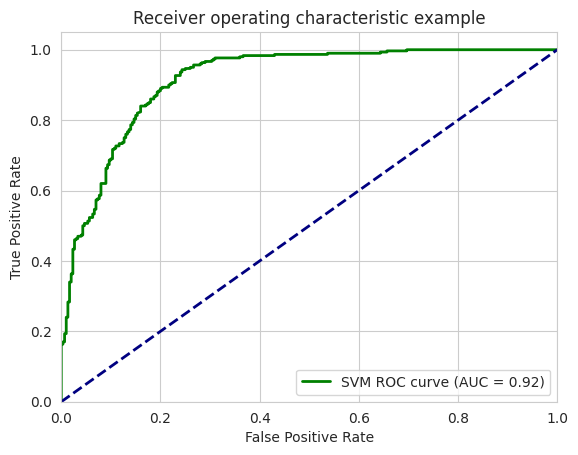

SVM Confusion Matrix: 
 [[254  46]
 [ 55 245]]
Sensitivity :  0.8466666666666667
Specificity :  0.8166666666666667
Precision :  0.8220064724919094
F1score :  0.8341543513957307
Accuracy :  0.8316666666666667


In [45]:
# Heatmap 10x
heatmap10x_flatten = np.array([image.flatten() for image in heatmap10x])
SVMCls(heatmap10x_flatten,labels10x)

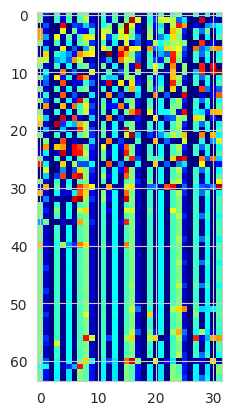

In [46]:
plt.imshow(heatmap10x[0])

Fitting SVM Classifier...
SVM Classifier Fitted...
81.5


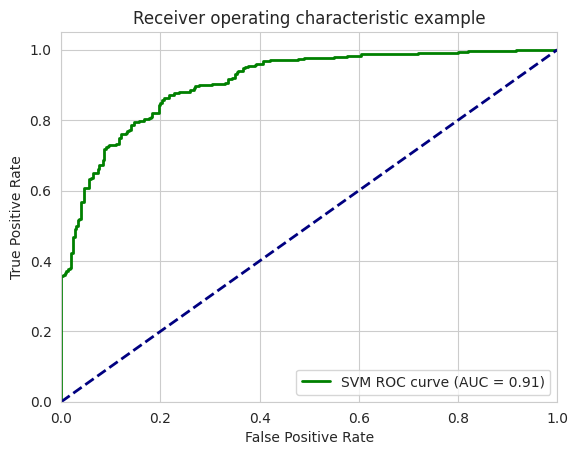

SVM Confusion Matrix: 
 [[265  35]
 [ 76 224]]
Sensitivity :  0.8833333333333333
Specificity :  0.7466666666666667
Precision :  0.7771260997067448
F1score :  0.8268330733229329
Accuracy :  0.815


In [47]:
# feature 10x
featured10x_flatten = np.array([image.flatten() for image in featured10x])
SVMCls(featured10x_flatten,labels10x)

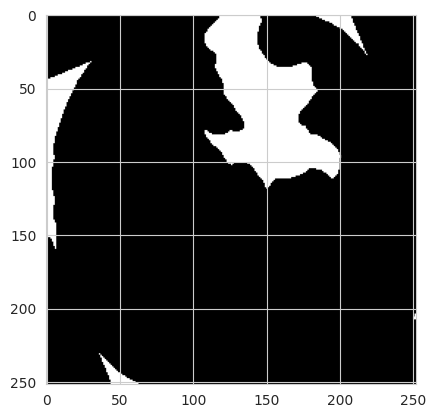

In [48]:
plt.imshow(featured10x[0])

In [49]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,cross_validate,cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [50]:
def eval(model,X,y,title):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    scores = cross_validate(model, X, y, cv=skf, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    print(title)
    print('accuracy: ', scores['test_accuracy'].mean())
    print('precision: ', scores['test_precision'].mean())
    print('recall: ', scores['test_recall'].mean())
    print('f1: ', scores['test_f1'].mean())
    print('roc_auc: ', scores['test_roc_auc'].mean())

In [86]:
def KSel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=random_state, stratify=y)
    k_range = range(1, 31)
    k_scores = []
    for k in k_range:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        clf = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
        k_scores.append(scores.mean())
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()

In [52]:
def KNNCls(X,y,k):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=random_state, stratify=y)
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    metrics(clf,X_test,y_test)

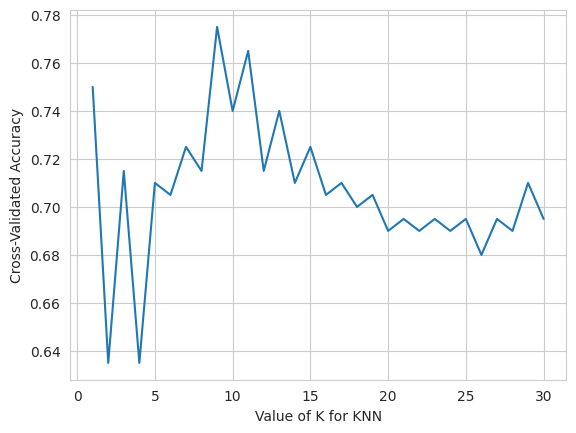

In [53]:
KSel(original_flatten,labels)

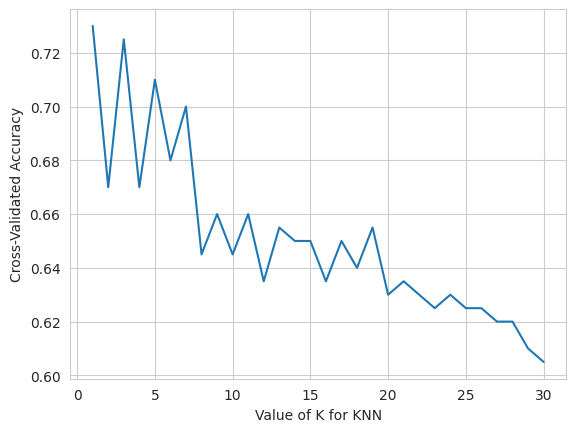

In [54]:
KSel(encoded_flatten,labels)

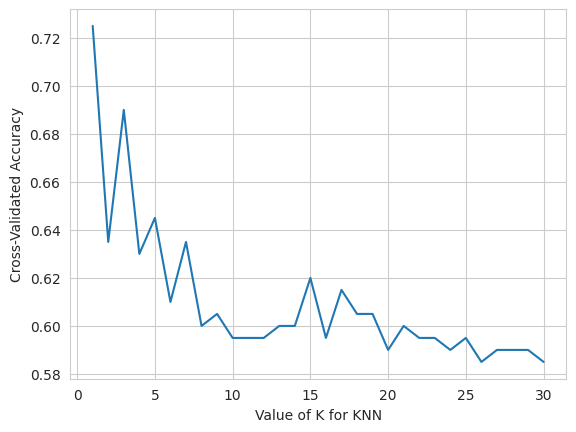

In [55]:
KSel(heatmap_flatten,labels)

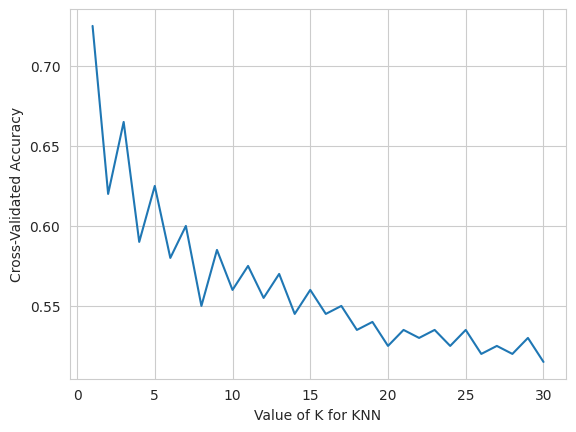

In [64]:
KSel(featured_flatten,labels)

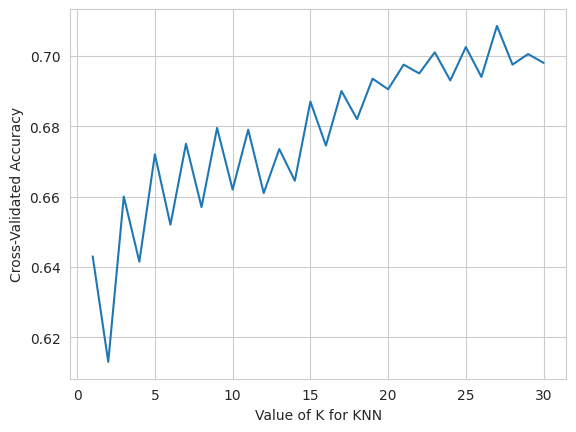

In [90]:
KSel(original10x_flatten,labels10x)

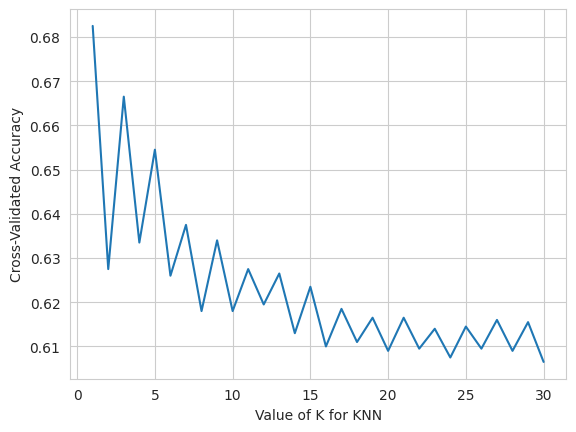

In [87]:
KSel(encoded10x_flatten,labels10x)

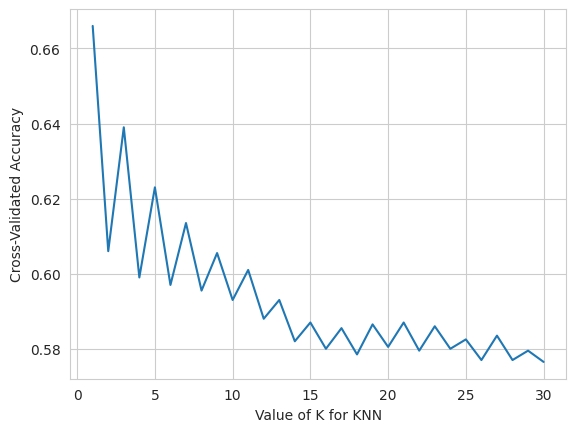

In [88]:
KSel(heatmap10x_flatten,labels10x)

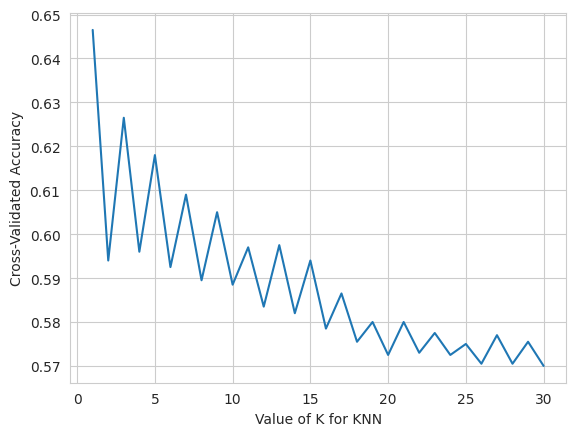

In [89]:
KSel(featured10x_flatten,labels10x)

75.0


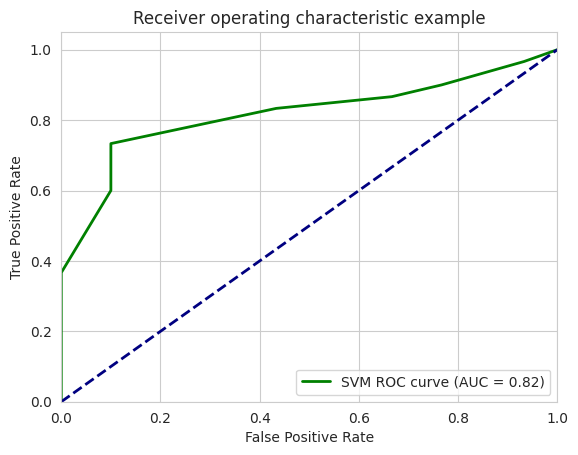

SVM Confusion Matrix: 
 [[27  3]
 [12 18]]
Sensitivity :  0.9
Specificity :  0.6
Precision :  0.6923076923076923
F1score :  0.782608695652174
Accuracy :  0.75


In [77]:
KNNCls(original_flatten,labels,10)

63.33333333333333


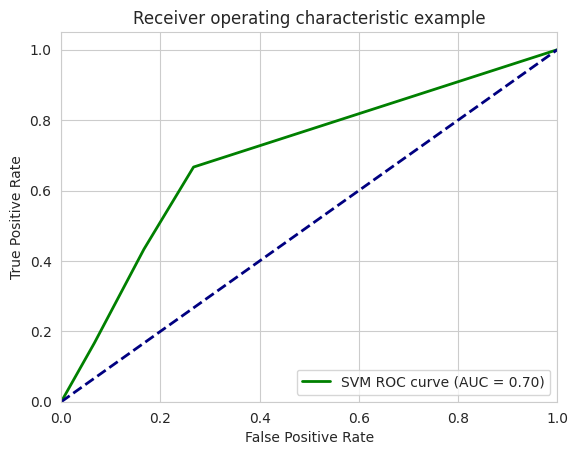

SVM Confusion Matrix: 
 [[25  5]
 [17 13]]
Sensitivity :  0.8333333333333334
Specificity :  0.43333333333333335
Precision :  0.5952380952380952
F1score :  0.6944444444444444
Accuracy :  0.6333333333333333


In [78]:
KNNCls(encoded_flatten,labels,3)

55.00000000000001


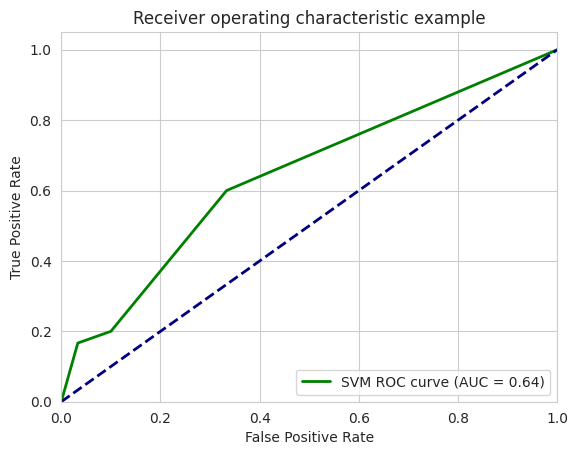

SVM Confusion Matrix: 
 [[27  3]
 [24  6]]
Sensitivity :  0.9
Specificity :  0.2
Precision :  0.5294117647058824
F1score :  0.6666666666666666
Accuracy :  0.55


In [79]:
KNNCls(heatmap_flatten,labels,3)

60.0


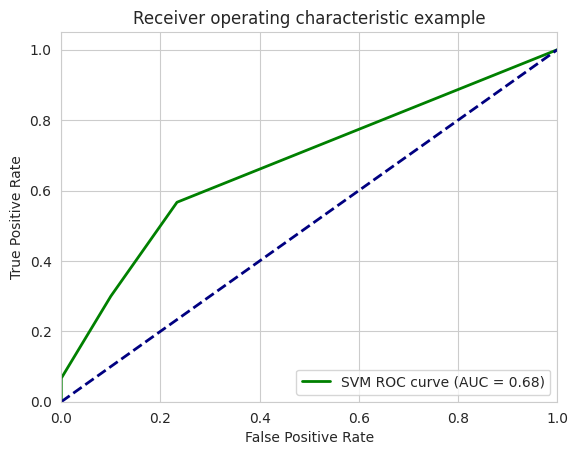

SVM Confusion Matrix: 
 [[27  3]
 [21  9]]
Sensitivity :  0.9
Specificity :  0.3
Precision :  0.5625
F1score :  0.6923076923076923
Accuracy :  0.6


In [80]:
KNNCls(featured_flatten,labels,3)

65.83333333333333


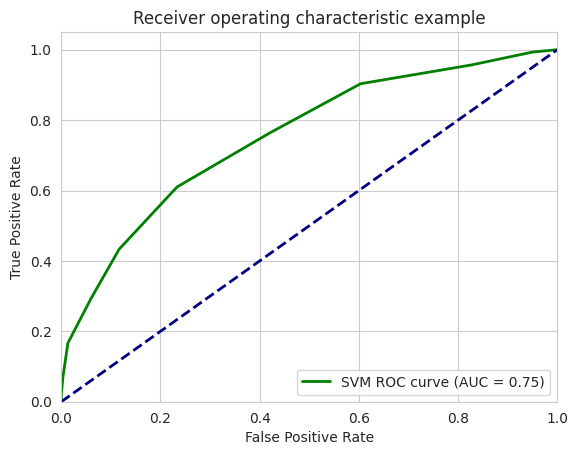

SVM Confusion Matrix: 
 [[265  35]
 [170 130]]
Sensitivity :  0.8833333333333333
Specificity :  0.43333333333333335
Precision :  0.6091954022988506
F1score :  0.7210884353741497
Accuracy :  0.6583333333333333


In [99]:
KNNCls(original10x_flatten,labels10x,10)

66.83333333333333


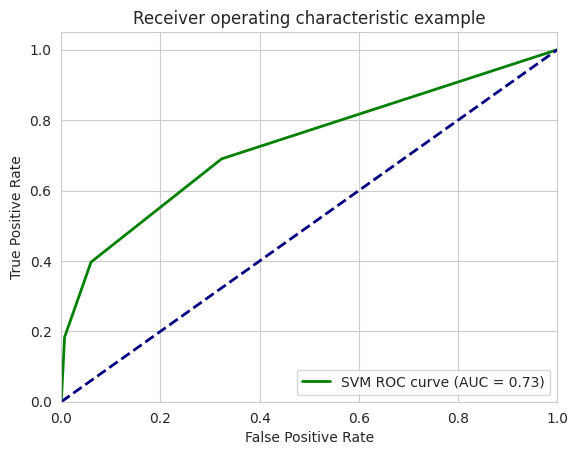

SVM Confusion Matrix: 
 [[282  18]
 [181 119]]
Sensitivity :  0.94
Specificity :  0.39666666666666667
Precision :  0.6090712742980562
F1score :  0.7391874180865007
Accuracy :  0.6683333333333333


In [93]:
KNNCls(encoded10x_flatten,labels10x,3)

65.5


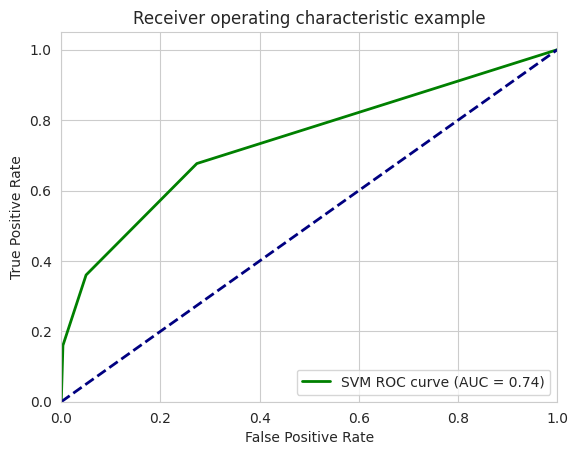

SVM Confusion Matrix: 
 [[285  15]
 [192 108]]
Sensitivity :  0.95
Specificity :  0.36
Precision :  0.5974842767295597
F1score :  0.7335907335907336
Accuracy :  0.655


In [94]:
KNNCls(heatmap10x_flatten,labels10x,3)

63.83333333333333


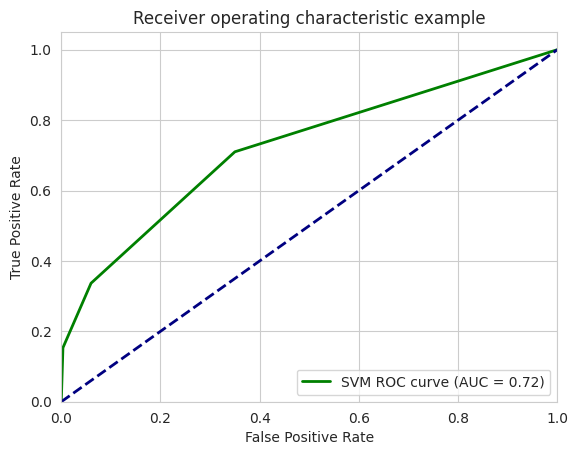

SVM Confusion Matrix: 
 [[282  18]
 [199 101]]
Sensitivity :  0.94
Specificity :  0.33666666666666667
Precision :  0.5862785862785863
F1score :  0.7221510883482715
Accuracy :  0.6383333333333333


In [95]:
KNNCls(featured10x_flatten,labels10x,3)

In [30]:
# AlexNet
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [31]:
def alex(input_shape):

    model = Sequential()
    #conv1
    model.add(Conv2D(96, (11, 11), strides=(1, 1),  padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    #conv2
    model.add(Conv2D(256, (5, 5), strides=(1, 1),  padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    #conv3
    model.add(Conv2D(384, (3, 3), strides=(1, 1),  padding='same', activation='relu'))
    #conv4
    model.add(Conv2D(384, (3, 3), strides=(1, 1),  padding='same', activation='relu'))
    #conv5
    model.add(Conv2D(256, (3, 3), strides=(1, 1),  padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    #fc5
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.8))
    #fc6
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.8))
    #fc7
    model.add(Dense(1, activation='sigmoid'))
    adam=Adam(learning_rate=1e-4)

    model.compile(optimizer=adam,loss='binary_crossentropy',metrics= [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ])
    return model

In [32]:
def metrics2(model,X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    print('accuracy: ', accuracy_score(y_test, y_pred))
    print('precision: ', precision_score(y_test, y_pred))
    print('recall: ', recall_score(y_test, y_pred))
    print('f1: ', f1_score(y_test, y_pred))
    print('roc_auc: ', roc_auc_score(y_test, y_pred))
    print('confusion_matrix: \n', confusion_matrix(y_test, y_pred))
    print('classification_report: \n', classification_report(y_test, y_pred))

In [33]:
def plot_roc_auc(model,X_test,y_test):
    svm_y_pred = model.predict(X_test)
    svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_pred)
    svm_auc = auc(svm_fpr, svm_tpr)
    plt.figure()
    plt.plot(svm_fpr, svm_tpr, color='green', lw=2, label='SVM ROC curve (AUC = %0.2f)' % svm_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()  # 混淆矩阵
    svm_pred = model.predict(X_test)
    cfm = confusion_matrix(y_test, svm_pred)
    print("SVM Confusion Matrix: \n", cfm)
    sensitivity = cfm[0, 0] / (cfm[0, 0] + cfm[0, 1])
    print("Sensitivity : ", sensitivity)
    specificity = cfm[1, 1] / (cfm[1, 0] + cfm[1, 1])
    print("Specificity : ", specificity)
    precision = cfm[0, 0] / (cfm[0, 0] + cfm[1, 0])
    print("Precision : ", precision)
    F1score = 2*cfm[0, 0] / (2*cfm[0, 0] + cfm[0, 1] + cfm[1, 0])
    print("F1score : ", F1score)
    acc = (cfm[0, 0] + cfm[1, 1]) / (cfm[0, 0] + cfm[0, 1] + cfm[1, 0] + cfm[1, 1])
    print("Accuracy : ", acc)

In [34]:
def alex_train(X,y,input_shape,name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=random_state, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=random_state, stratify=y_train)
    model = alex(input_shape)
    model.summary()
    history = model.fit(X_train, y_train, epochs=1000, batch_size=16, validation_data=(X_val, y_val),callbacks=[keras.callbacks.ModelCheckpoint('./models/'+name+'.h5', monitor='val_loss', save_best_only=True, verbose=1)] )
    metrics2(model,X_test,y_test)
    plot_roc_auc(model,X_test,y_test)
    return model, history

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 124, 124, 96)      11712     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 61, 61, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 61, 61, 256)       614656    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 30, 30, 384)       885120    
                                                                 
 conv2d_22 (Conv2D)          (None, 30, 30, 384)      

2023-06-05 16:33:33.717339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7/7 [==============================] - ETA: 0s - loss: 22.2466 - tp: 22.0000 - fp: 33.0000 - tn: 16.0000 - fn: 27.0000 - accuracy: 0.3878 - precision: 0.4000 - recall: 0.4490 - auc: 0.3950 - prc: 0.4361
Epoch 1: val_loss improved from inf to 7.34512, saving model to ./models/alex.h5
7/7 [==============================] - 7s 454ms/step - loss: 22.2466 - tp: 22.0000 - fp: 33.0000 - tn: 16.0000 - fn: 27.0000 - accuracy: 0.3878 - precision: 0.4000 - recall: 0.4490 - auc: 0.3950 - prc: 0.4361 - val_loss: 7.3451 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 21.0000 - val_fn: 21.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 7.7510 - tp: 27.0000 - fp: 21.0000 - tn: 28.0000 - fn: 22.0000 - accuracy: 0.5612 - precision: 0.5625 - recall: 0.5510 - auc: 0.5664 - prc: 0.5473
Epoch 2: val_loss improved from 7.34512 to 1.77595, saving model to ./models/alex.h

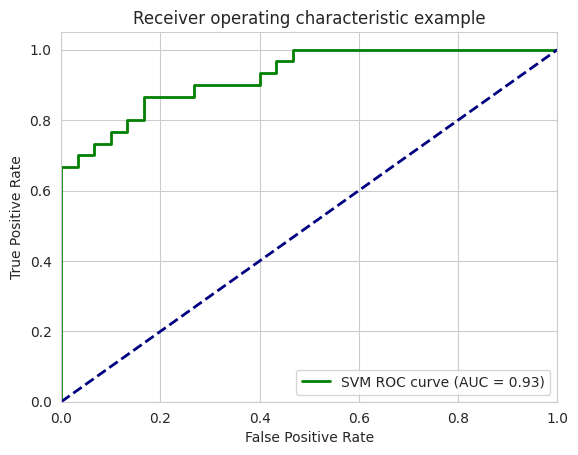

2/2 [==============================] - 0s 8ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [39]:
# Original
original_resized = np.array([cv2.resize(i, (124, 124)) for i in original])
originModel,originHist = alex_train(original_resized,labels,(124,124,1),'original')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 124, 124, 96)      11712     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 61, 61, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 256)       614656    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 30, 30, 384)       885120    
                                                                 
 conv2d_27 (Conv2D)          (None, 30, 30, 384)      

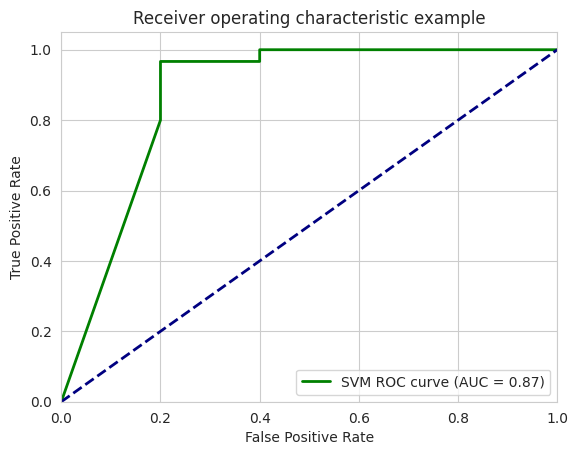

2/2 [==============================] - 0s 8ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [42]:
# featured
featured_resized = np.array([cv2.resize(i, (124, 124)) for i in featured])
featuredModel,featuredHist = alex_train(featured_resized,labels,(124,124,1),'featured')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 64, 32, 96)        11712     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 31, 15, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 31, 15, 256)       614656    
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 15, 7, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 15, 7, 384)        885120    
                                                                 
 conv2d_37 (Conv2D)          (None, 15, 7, 384)       

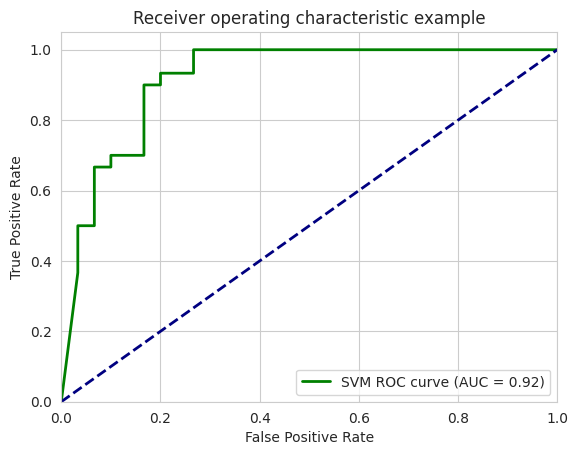

2/2 [==============================] - 0s 2ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [44]:
# encoded
encodedModel,encodedHist = alex_train(encoded,labels,(64,32,1),'encoded')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 64, 32, 96)        34944     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 31, 15, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 31, 15, 256)       614656    
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 15, 7, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 15, 7, 384)        885120    
                                                                 
 conv2d_47 (Conv2D)          (None, 15, 7, 384)       

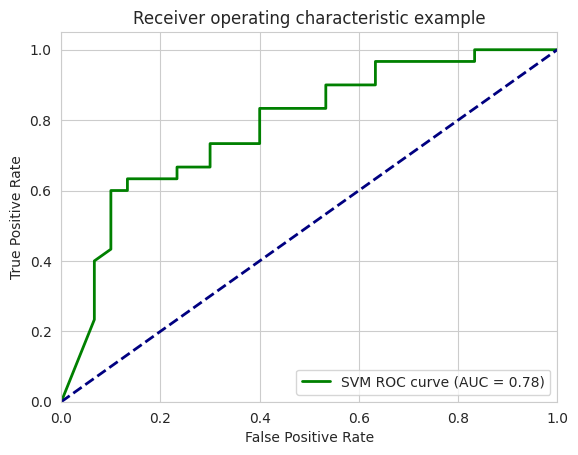

2/2 [==============================] - 0s 2ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [46]:
# heatmap
heatmapModel,heatmapHist = alex_train(heatmap,labels,(64,32,3),'heatmap')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 124, 124, 96)      11712     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 61, 61, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 61, 61, 256)       614656    
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 30, 30, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 30, 30, 384)       885120    
                                                                 
 conv2d_52 (Conv2D)          (None, 30, 30, 384)      

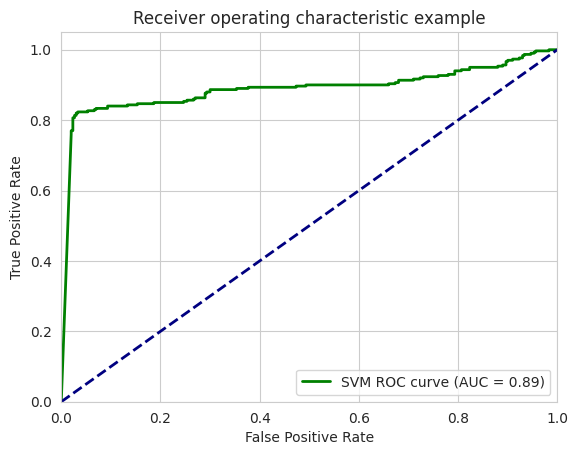

19/19 [==============================] - 0s 8ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [48]:
# original10x
original10x_resized = np.array([cv2.resize(i, (124, 124)) for i in original10x])
origin10xModel,origin10xHist = alex_train(original10x_resized,labels10x,(124,124,1),'original10x')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 124, 124, 96)      11712     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 61, 61, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 61, 61, 256)       614656    
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 30, 30, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 30, 30, 384)       885120    
                                                                 
 conv2d_57 (Conv2D)          (None, 30, 30, 384)      

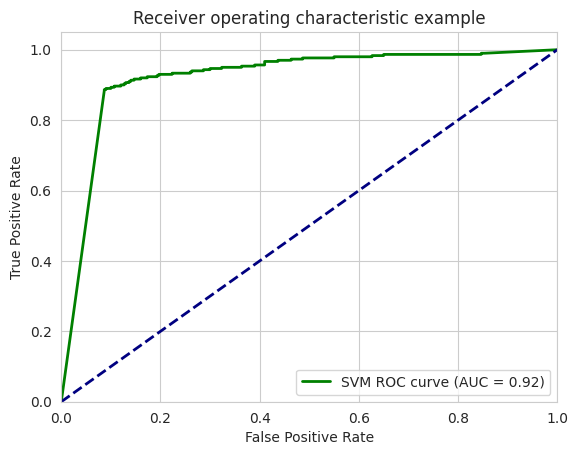

19/19 [==============================] - 0s 8ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [49]:
# featured10x
featured10x_resized = np.array([cv2.resize(i, (124, 124)) for i in featured10x])
featured10xModel,featured10xHist = alex_train(featured10x_resized,labels10x,(124,124,1),'featured10x')

In [35]:
# alexnet+svm
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense,Activation

In [36]:
def alex_svm(input_shape):

    model = Sequential()
    #conv1
    model.add(Conv2D(96, (11, 11), strides=(1, 1),  padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    #conv2
    model.add(Conv2D(256, (5, 5), strides=(1, 1),  padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    #conv3
    model.add(Conv2D(384, (3, 3), strides=(1, 1),  padding='same', activation='relu'))
    #conv4
    model.add(Conv2D(384, (3, 3), strides=(1, 1),  padding='same', activation='relu'))
    #conv5
    model.add(Conv2D(256, (3, 3), strides=(1, 1),  padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    #fc5
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.8))
    #fc6
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.8))
    #fc7
    model.add(Dense(1, kernel_regularizer=l2(0.01)))
    model.add(Activation('linear'))
    model.compile(loss='hinge',
                  optimizer='adadelta',metrics= [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ])
    return model

In [43]:
def alex_svm_train(X,y,input_shape,name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=random_state, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=random_state, stratify=y_train)
    model = alex_svm(input_shape)
    model.summary()
    history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val),callbacks=[keras.callbacks.ModelCheckpoint('./models/'+name+'_svm.h5', monitor='val_loss', save_best_only=True, verbose=1)] )
    metrics2(model,X_test,y_test)
    plot_roc_auc(model,X_test,y_test)
    return model, history

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 124, 124, 96)      11712     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 61, 61, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 61, 61, 256)       614656    
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 30, 30, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 30, 30, 384)       885120    
                                                                 
 conv2d_77 (Conv2D)          (None, 30, 30, 384)     

2023-06-05 18:30:52.803613: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55571656a100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-05 18:30:52.803711: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-06-05 18:30:53.059341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-05 18:30:54.887146: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 [==============================] - ETA: 0s - loss: 7.3284 - tp: 25.0000 - fp: 26.0000 - tn: 23.0000 - fn: 24.0000 - accuracy: 0.4898 - precision: 0.4902 - recall: 0.5102 - auc: 0.5002 - prc: 0.5033
Epoch 1: val_loss improved from inf to 1.62907, saving model to ./models/original_svm.h5
7/7 [==============================] - 10s 831ms/step - loss: 7.3284 - tp: 25.0000 - fp: 26.0000 - tn: 23.0000 - fn: 24.0000 - accuracy: 0.4898 - precision: 0.4902 - recall: 0.5102 - auc: 0.5002 - prc: 0.5033 - val_loss: 1.6291 - val_tp: 21.0000 - val_fp: 21.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.5476 - val_prc: 0.5250
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 10.9253 - tp: 25.0000 - fp: 32.0000 - tn: 17.0000 - fn: 24.0000 - accuracy: 0.4286 - precision: 0.4386 - recall: 0.5102 - auc: 0.4286 - prc: 0.4563
Epoch 2: val_loss improved from 1.62907 to 0.96897, saving model to ./models/origin

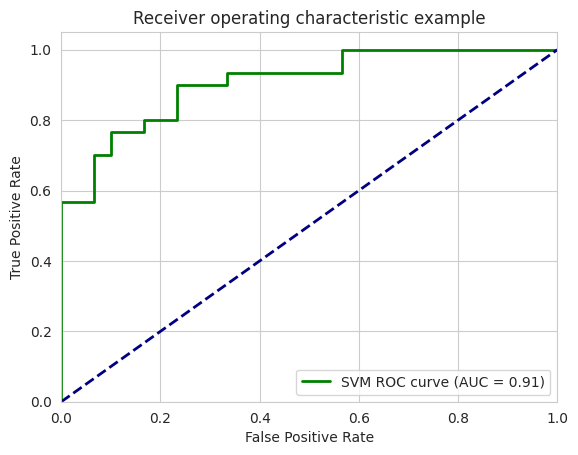

2/2 [==============================] - 0s 8ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [63]:
# original
originSvmModel,originSvmHist = alex_svm_train(original_resized,labels,(124,124,1),'original')

In [42]:
# featured
featured_resized = np.array([cv2.resize(i, (124, 124)) for i in featured])
featuredSvmModel,featuredSvmHist = alex_svm_train(featured_resized,labels,(124,124,1),'featured')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 124, 124, 96)      11712     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 61, 61, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 61, 61, 256)       614656    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 30, 30, 384)       885120    
                                                                 
 conv2d_22 (Conv2D)          (None, 30, 30, 384)      

KeyboardInterrupt: 

In [ ]:
# encoded
encodedSvmModel,encodedSvmHist = alex_svm_train(encoded,labels,(64,32,1),'encoded')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 64, 32, 96)        34944     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 31, 15, 96)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 31, 15, 256)       614656    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 7, 256)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 15, 7, 384)        885120    
                                                                 
 conv2d_17 (Conv2D)          (None, 15, 7, 384)       

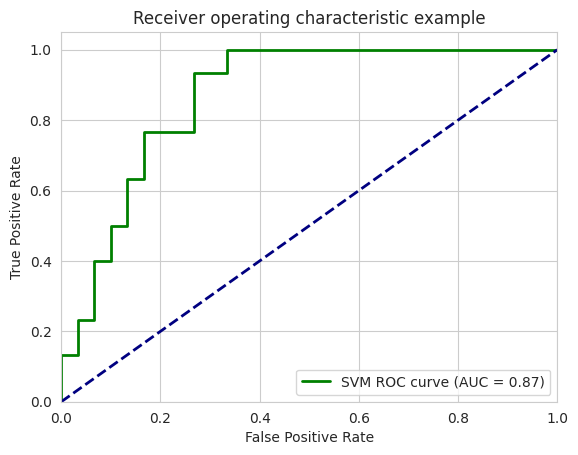

2/2 [==============================] - 0s 2ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [40]:
# heatmap
heatmapSvmModel,heatmapSvmHist = alex_svm_train(heatmap,labels,(64,32,3),'heatmap')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 124, 124, 96)      11712     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 61, 61, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 256)       614656    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 30, 30, 384)       885120    
                                                                 
 conv2d_27 (Conv2D)          (None, 30, 30, 384)      

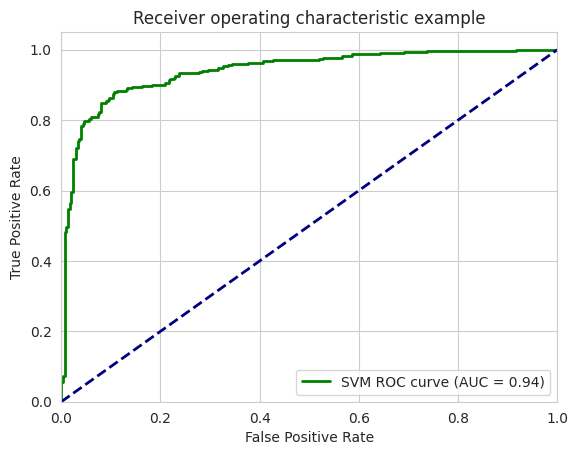

19/19 [==============================] - 0s 8ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [45]:
# original10x
original10x_resized = np.array([cv2.resize(i, (124, 124)) for i in original10x])
origin10xSvmModel,origin10xSvmHist = alex_svm_train(original10x_resized,labels10x,(124,124,1),'original10x')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 124, 124, 96)      11712     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 61, 61, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 61, 61, 256)       614656    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 30, 30, 384)       885120    
                                                                 
 conv2d_32 (Conv2D)          (None, 30, 30, 384)      

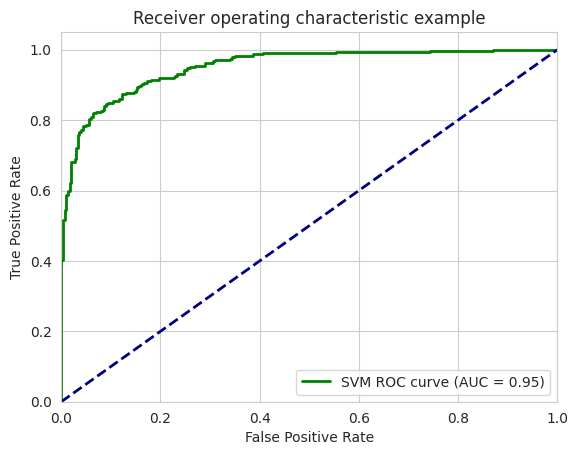

19/19 [==============================] - 0s 8ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [46]:
# featured10x
featured10x_resized = np.array([cv2.resize(i, (124, 124)) for i in featured10x])
featured10xSvmModel,featured10xSvmHist = alex_svm_train(featured10x_resized,labels10x,(124,124,1),'featured10x')